# Visualization of the Holo Lens 2 Data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import math
import pygame
import open3d as o3d
import requests
#from Rotate import Rotate
#from Visualize import Visualize

pygame 2.6.1 (SDL 2.28.4, Python 3.8.10)
Hello from the pygame community. https://www.pygame.org/contribute.html
Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:
WHITE = (1, 1, 1)
RED = (255, 0, 0)
GREEN = (0, 255, 0)
YELLOW = (255, 255, 0)
BLUE = (0, 0, 255)
PURPLE = (128, 0, 128)  # Farbe für den Bauplan
WIDTH, HEIGHT = 800, 600

In [4]:
mesh = o3d.io.read_triangle_mesh("data2/combined_mesh1.ply")
#bauplan = pd.read_csv("/Users/noah/Documents/github/hololens/Data/data15/bauplan.csv", delimiter =";")

In [5]:
mesh.compute_vertex_normals()
o3d.visualization.draw_geometries([mesh])

In [6]:
def vorverarbeiten(df):
    df = df.rename(columns={'Timestamp': 'timestamp'})
    df = df.rename(columns={'HoloLens Eye Tracker Timestamp': 'eye_tracker_time'})
    df = df.rename(columns={'Combined Gaze Origin X': 'combined_gaze_X'})
    df = df.rename(columns={'Combined Gaze Origin Y': 'combined_gaze_Y'})
    df = df.rename(columns={'Combined Gaze Origin Z': 'combined_gaze_Z'})
    df = df.rename(columns={'Combined Gaze Direction X': 'combined_gaze_dir_X'})
    df = df.rename(columns={'Combined Gaze Direction Y': 'combined_gaze_dir_Y'})
    df = df.rename(columns={'Combined Gaze Direction Z': 'combined_gaze_dir_Z'})
    df = df.rename(columns={'Image Filename': 'PATH'})
    df = df.rename(columns={'HoloLens Position X': 'position_X'})
    df = df.rename(columns={'HoloLens Position Y': 'position_Y'})
    df = df.rename(columns={'HoloLens Position Z': 'position_Z'})
    df['PATH'] = df['PATH'].str.replace(r'data0\\images\\', '', regex=True)
    return df

In [7]:
def rotate_mesh(angle_degrees):
    angle_radians = np.radians(angle_degrees)
    rotation_matrix = mesh.get_rotation_matrix_from_xyz((0, 0, angle_radians))
    mesh.rotate(rotation_matrix, center=(0, 0, 0))
rotate_mesh(90)

In [8]:

df = pd.read_csv("data2/data.csv", delimiter=";")
#df = vorverarbeiten(df)

In [9]:
def project_3d_to_2d(point):
    try:
        x, y, z = point
        max_coord = 1e6  # Adjust this value based on your data range
        x = max(min(x, max_coord), -max_coord)
        z = max(min(z, max_coord), -max_coord)
        screen_x = int(x * 100 + WIDTH / 2)
        screen_y = int(-z * 100 + HEIGHT / 2)
        screen_x = max(0, min(screen_x, WIDTH - 1))
        screen_y = max(0, min(screen_y, HEIGHT - 1))
        return screen_x, screen_y
    except:
        return 0,0


def get_vec(forward, up):
    combined = (np.array(forward) + np.array(up))
    combined = combined / np.linalg.norm(combined)
    return combined

def create_raycasting_scene(mesh):
    if len(mesh.triangles) == 0:
        return None
    if not mesh.has_vertex_normals():
        mesh.compute_vertex_normals()
    if not mesh.has_triangle_normals():
        mesh.compute_triangle_normals()
    try:
        scene = o3d.t.geometry.RaycastingScene()
        mesh_t = o3d.t.geometry.TriangleMesh.from_legacy(mesh)
        scene.add_triangles(mesh_t)
        return scene
    except Exception as e:
        print(f"Error creating raycasting scene: {e}")
        return None

def find_intersection(scene, origin, direction, length=10.0):
    direction = direction / np.linalg.norm(direction)
    direction = direction * length
    rays = np.array([[origin[0], origin[1], origin[2], 
                      direction[0], direction[1], direction[2]]], dtype=np.float32)
    rays_tensor = o3d.core.Tensor(rays)
    ans = scene.cast_rays(rays_tensor)
    try:
        if ans['t_hit'].numpy()[0] > 0:
            hit_point = origin + direction * ans['t_hit'].numpy()[0]
            return hit_point
    except Exception:
        return None
    return None

In [10]:
import re
def extract_vector(vector_string):
    # Remove brackets and split the string
    values = re.findall(r'-?\d+\.?\d*', vector_string)
    return np.array([float(value) for value in values])

In [11]:
pygame.init()

screen = pygame.display.set_mode((WIDTH, HEIGHT))
pygame.display.set_caption("2D HoloLens Visualization")

scene = create_raycasting_scene(mesh)

if scene is None:
    print("Failed to create raycasting scene. Exiting.")
    exit()

mesh_2d = [project_3d_to_2d(v) for v in np.asarray(mesh.vertices)]
#bauplan_2d = [project_3d_to_2d([point['x'], point['z'], point['y']]) for _, point in bauplan.iterrows()]

running = True
clock = pygame.time.Clock()

for index, row in df.iterrows():
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            running = False

    if not running:
        break

    screen.fill(WHITE)

    for triangle in np.asarray(mesh.triangles):
        pygame.draw.polygon(screen, BLUE, [mesh_2d[i] for i in triangle], 1)
    
    #if len(bauplan_2d) > 1:
        #pygame.draw.lines(screen, PURPLE, False, bauplan_2d, 2)
    


    pos = extract_vector(row["Position"])
    forward = extract_vector(row['Forward'])
    up = extract_vector(row['Up'])

    hololens_pos_2d = project_3d_to_2d(pos)

    pygame.draw.circle(screen, RED, hololens_pos_2d, 5)

    gaze_vec = get_vec(forward, up)
    
    intersection_point = find_intersection(scene, pos, gaze_vec)

    if intersection_point is not None:
        intersection_point_2d = project_3d_to_2d(intersection_point)
        x, y = intersection_point_2d
        if x != 0 and y != 0:
            pygame.draw.line(screen, GREEN, hololens_pos_2d, intersection_point_2d, 2)
            pygame.draw.circle(screen, YELLOW, intersection_point_2d, 8)

    pygame.display.flip()

    clock.tick(30)

pygame.quit()

## Zimmer Mapping
### Rotation of Mesh + Selction of important area

In [12]:
import pygame
import pyvista as pv
import numpy as np

# Konstanten für die Bildschirmgröße
WIDTH, HEIGHT = 800, 600
WHITE = (255, 255, 255)
BLUE = (0, 0, 255)
RED = (255, 0, 0)
GREEN = (0, 255, 0)
BLACK = (0, 0, 0)
GRAY = (169, 169, 169)
ORANGE = (255, 165, 0)
YELLOW = (255, 255, 0)
PURPLE = (128, 0, 128)
PINK = (255, 192, 203)
TURQUOISE = (64, 224, 208)
DARK_BLUE = (0, 0, 139)
OLIVE = (128, 128, 0)
LIGHT_GREEN = (144, 238, 144)

# 3D-zu-2D-Projektion (orthografische Projektion)
def project_3d_to_2d_2(x,y):
    # Einfache Projektion, ohne Perspektive
    return int(x * 100 + WIDTH // 2), int(-y * 100 + HEIGHT // 2)

#scene

#scene = create_raycasting_scene(mesh)


# Pygame-Initialisierung
pygame.init()
screen = pygame.display.set_mode((WIDTH, HEIGHT))
pygame.display.set_caption("3D to 2D Mesh Projection")
clock = pygame.time.Clock()

# Lade das Mesh mit PyVista (ersetze den Pfad zur .ply-Datei)
mesh = pv.read("data2/combined_mesh1.ply")  # Passe den Pfad zur .ply-Datei an
mesh = mesh.rotate_x(90)
mesh = mesh.rotate_z(9)

# Extrahiere die Vertices und die Faces
vertices = mesh.points  # 3D-Koordinaten der Vertices
faces = mesh.faces.reshape(-1, 4)[:, 1:]  # Indizes der Dreiecke

# Erstelle eine Oberfläche für das Mesh
mesh_surface = pygame.Surface((WIDTH, HEIGHT), pygame.SRCALPHA)
mesh_surface.fill((255, 255, 255, 0))  # Transparenter weißer Hintergrund

# Zeichne das Mesh einmal
for index, face in enumerate(faces):
    if index % 2 == 1:  # Überspringt jedes zweite Element (1, 3, 5, ...)
        points_2d = []
        for i in face:
            x, y, z = vertices[i]
            # 
            if z <= -0.6 and ((x <= 1.4 and not (y >= 1.5 or y <= -1.4)) or (x >= 1.4 and not (y >= 0.5 or y <= -1.4))):
                points_2d.append(project_3d_to_2d_2(x, y))
                try:
                    pygame.draw.polygon(mesh_surface, BLUE, points_2d, 1)
                except Exception as e:
                    print(f"{e}")
            else:
                points_2d.append(project_3d_to_2d_2(x, y))
                try:
                    pygame.draw.polygon(mesh_surface, RED, points_2d, 1)
                except Exception as e:
                    print(f"{e}")

# Ereignisbehandlung und Visualisierung
running = True
while running:
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            running = False

    # Hintergrundfarbe setzen
    screen.fill(WHITE)

    # Zeichne das vorgerenderte Mesh
    screen.blit(mesh_surface, (0, 0))

    # Bildschirm aktualisieren
    pygame.display.flip()

    # Framerate auf 30 FPS setzen
    clock.tick(30)

# Pygame beenden
pygame.quit()


points argument must contain 2 or more points
points argument must contain 2 or more points
points argument must contain 2 or more points
points argument must contain 2 or more points
points argument must contain 2 or more points
points argument must contain 2 or more points
points argument must contain 2 or more points
points argument must contain 2 or more points
points argument must contain 2 or more points
points argument must contain 2 or more points
points argument must contain 2 or more points
points argument must contain 2 or more points
points argument must contain 2 or more points
points argument must contain 2 or more points
points argument must contain 2 or more points
points argument must contain 2 or more points
points argument must contain 2 or more points
points argument must contain 2 or more points
points argument must contain 2 or more points
points argument must contain 2 or more points
points argument must contain 2 or more points
points argument must contain 2 or 

## Bild

In [23]:
from time import sleep
import pygame
import os

# Konstanten für die Bildschirmgröße
WIDTH, HEIGHT = 1000, 600
WHITE = (255, 255, 255)

# Pygame-Initialisierung
pygame.init()
screen = pygame.display.set_mode((WIDTH, HEIGHT))
pygame.display.set_caption("Image Viewer")
clock = pygame.time.Clock()

# Bildpfade definieren
image_folder = "data2/images"  # Ordner, in dem die Bilder gespeichert sind
image_files = sorted([f for f in os.listdir(image_folder) if f.endswith(".jpg")])

# Ereignisbehandlung und Visualisierung
running = True
current_image_index = 0

while running:
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            running = False

    # Hintergrundfarbe setzen
    screen.fill(WHITE)

    # Aktuelles Bild anzeigen
    scale = 1
    if 0 <= current_image_index < len(image_files):
        image_path = os.path.join(image_folder, image_files[current_image_index])
        image = pygame.image.load(image_path)
        image = pygame.transform.scale(image, (760 * scale, 428 * scale))
        screen.blit(image, (0, 0))
        current_image_index = current_image_index + 1

    # Bildschirm aktualisieren
    pygame.display.flip()

    # Framerate auf 30 FPS setzen
    clock.tick(30)

# Pygame beenden
pygame.quit()


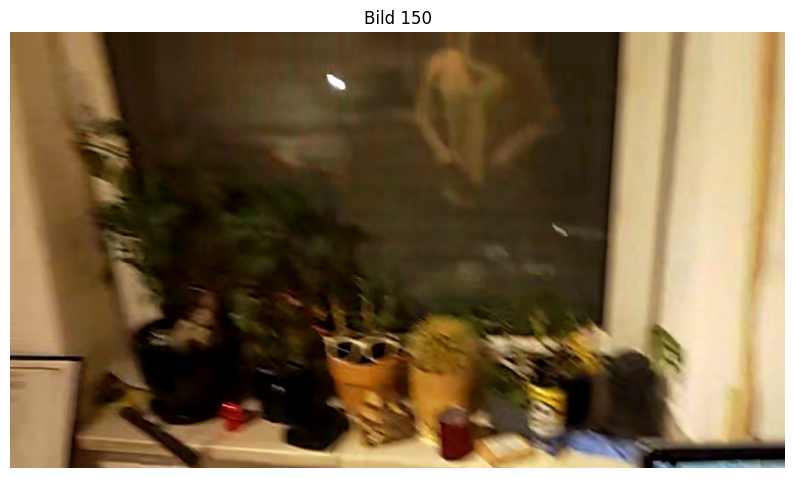

In [32]:
import matplotlib.pyplot as plt
import os

# Bildpfade definieren
image_folder = "data2/images"  # Ordner, in dem die Bilder gespeichert sind
image_files = sorted([f for f in os.listdir(image_folder) if f.endswith(".jpg")])

# Funktion zum Anzeigen eines Bildes bei einem bestimmten Index
def show_image_at_index(index):
    if 0 <= index < len(image_files):
        image_path = os.path.join(image_folder, image_files[index])
        image = plt.imread(image_path)
        
        plt.figure(figsize=(10, 6))
        plt.imshow(image)
        plt.axis('off')  # Entfernt die Achsen
        plt.title(f"Bild {index}")
        plt.show()
    else:
        print(f"Kein Bild für Index {index} verfügbar.")

# Beispielaufruf: Zeigt das Bild bei Index 5 an
show_image_at_index(150)


## + HoloLensPosition + Kamera

In [17]:
from time import sleep
import pygame
import pyvista as pv
import numpy as np
import os

# Konstanten für die Bildschirmgröße
WIDTH, HEIGHT = 1000, 600
WHITE = (255, 255, 255)
BLUE = (0, 0, 255)
RED = (255, 0, 0)
BLACK = (0, 0, 0)
BUTTON_COLOR = (200, 0, 0)
BUTTON_HOVER_COLOR = (255, 0, 0)

# Pygame-Initialisierung
pygame.init()
screen = pygame.display.set_mode((WIDTH, HEIGHT))
pygame.display.set_caption("3D to 2D Mesh Projection")
clock = pygame.time.Clock()

# Button-Größe und -Position
button_width, button_height = 100, 50
button_x, button_y = WIDTH - button_width - 10, HEIGHT - button_height - 10

# Lade das Mesh mit PyVista (ersetze den Pfad zur .ply-Datei)
mesh = pv.read("data2/combined_mesh1.ply")  # Passe den Pfad zur .ply-Datei an
mesh = mesh.rotate_x(90)
mesh = mesh.rotate_z(9)

# Extrahiere die Vertices und die Faces
vertices = mesh.points  # 3D-Koordinaten der Vertices
faces = mesh.faces.reshape(-1, 4)[:, 1:]  # Indizes der Dreiecke

# Bildpfade definieren
image_folder = "data2/images"  # Ordner, in dem die Bilder gespeichert sind
image_files = sorted([f for f in os.listdir(image_folder) if f.endswith(".jpg")])

# Funktion zur Projektion von 3D- zu 2D-Punkten (Dummy-Implementation)
def project_3d_to_2d(point):
    return int(point[0] * 100 + WIDTH // 2), int(-point[1] * 100 + HEIGHT // 2)

def project_3d_to_2d_2(x, y):
    return int(x * 100 + WIDTH // 2), int(-y * 100 + HEIGHT // 2)

# Rotationsmatrix um die X-Achse
def rotate_x(point, angle):
    angle_rad = np.radians(angle)
    rotation_matrix = np.array([
        [1, 0, 0],
        [0, np.cos(angle_rad), -np.sin(angle_rad)],
        [0, np.sin(angle_rad), np.cos(angle_rad)]
    ])
    try: 
        return np.dot(rotation_matrix, point)
    except Exception as e:
        print(e)
        return [0, 0, 0]

# Rotationsmatrix um die Z-Achse
def rotate_z(point, angle):
    angle_rad = np.radians(angle)
    rotation_matrix = np.array([
        [np.cos(angle_rad), -np.sin(angle_rad), 0],
        [np.sin(angle_rad), np.cos(angle_rad), 0],
        [0, 0, 1]
    ])
    try: 
        return np.dot(rotation_matrix, point)
    except Exception as e:
        print(e)
        return [0, 0, 0]

# Ereignisbehandlung und Visualisierung
running = True
current_image_index = 0

while running:
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            running = False
        elif event.type == pygame.MOUSEBUTTONDOWN:
            mouse_pos = pygame.mouse.get_pos()
            # Prüfen, ob der Button angeklickt wurde
            if button_x <= mouse_pos[0] <= button_x + button_width and button_y <= mouse_pos[1] <= button_y + button_height:
                running = False

    # Hintergrundfarbe setzen
    screen.fill(WHITE)

    # Zeichnen des Buttons
    mouse_pos = pygame.mouse.get_pos()
    button_color = BUTTON_HOVER_COLOR if button_x <= mouse_pos[0] <= button_x + button_width and button_y <= mouse_pos[1] <= button_y + button_height else BUTTON_COLOR
    pygame.draw.rect(screen, button_color, (button_x, button_y, button_width, button_height))

    font = pygame.font.Font(None, 24)
    button_text = font.render("Beenden", True, WHITE)
    screen.blit(button_text, (button_x + 10, button_y + 15))
    translation_to_right = 200
    # Zeichnen der 2D-Projektion der Dreiecke
    for index2, face in enumerate(faces):
        if index2 % 10 == 1:  # Überspringt jedes zweite Element
            points_2d = []
            for i in face:
                x, y, z = vertices[i]
                if z <= -0.6 and ((x <= 1.4 and not (y >= 1.5 or y <= -1.4)) or (x >= 1.4 and not (y >= 0.5 or y <= -1.4))):
                    position = project_3d_to_2d_2(x,y)
                    x1, x2 = position
                    x1 = x1 + translation_to_right
                    position = x1, x2
                    points_2d.append(position)
            try:
                pygame.draw.polygon(screen, BLUE, points_2d, 1)
            except Exception as e:
                pass

    # Aktuelles Bild anzeigen
    scale = 0.5
    if 0 <= current_image_index < len(image_files):
        image_path = os.path.join(image_folder, image_files[current_image_index])
        image = pygame.image.load(image_path)
        image = pygame.transform.scale(image, (760 * scale, 428 * scale))
        screen.blit(image, (30, 200))
        current_image_index = current_image_index + 1

    # Beispielkreis zeichnen
    pos = extract_vector(df["Position"].iloc[current_image_index - 1])
    pos_rotated = rotate_x(pos, 90)  # Rotation um die X-Achse
    pos_rotated = rotate_z(pos_rotated, 9)  # Rotation um die Z-Achse
    hololens_pos_2d = project_3d_to_2d(pos_rotated)
    x,y = hololens_pos_2d
    x = x + translation_to_right
    hololens_pos_2d = (x,y)
    
    if hololens_pos_2d != (700, 300):    # Fehler bei Berechnung
        pygame.draw.circle(screen, RED, hololens_pos_2d, 10)
    
    # Bildschirm aktualisieren
    pygame.display.flip()

    # Framerate auf 30 FPS setzen
    clock.tick(30)

# Pygame beenden
pygame.quit()


##  + GazeDirektion

In [18]:
from time import sleep
import pygame
import pyvista as pv
import numpy as np
import os

# Konstanten für die Bildschirmgröße
WIDTH, HEIGHT = 1000, 600
WHITE = (255, 255, 255)
BLUE = (0, 0, 255)
RED = (255, 0, 0)
BLACK = (0, 0, 0)
BUTTON_COLOR = (200, 0, 0)
BUTTON_HOVER_COLOR = (255, 0, 0)

# Pygame-Initialisierung
pygame.init()
screen = pygame.display.set_mode((WIDTH, HEIGHT))
pygame.display.set_caption("3D to 2D Mesh Projection")
clock = pygame.time.Clock()

# Button-Größe und -Position
button_width, button_height = 100, 50
button_x, button_y = WIDTH - button_width - 10, HEIGHT - button_height - 10

# Lade das Mesh mit PyVista (ersetze den Pfad zur .ply-Datei)
mesh = pv.read("data2/combined_mesh1.ply")  # Passe den Pfad zur .ply-Datei an
mesh = mesh.rotate_x(90)
mesh = mesh.rotate_z(9)

# Extrahiere die Vertices und die Faces
vertices = mesh.points  # 3D-Koordinaten der Vertices
faces = mesh.faces.reshape(-1, 4)[:, 1:]  # Indizes der Dreiecke

# Bildpfade definieren
image_folder = "data2/images"  # Ordner, in dem die Bilder gespeichert sind
image_files = sorted([f for f in os.listdir(image_folder) if f.endswith(".jpg")])

# Funktion zur Projektion von 3D- zu 2D-Punkten (Dummy-Implementation)
def project_3d_to_2d(point):
    return int(point[0] * 100 + WIDTH // 2), int(-point[1] * 100 + HEIGHT // 2)

def project_3d_to_2d_2(x, y):
    return int(x * 100 + WIDTH // 2), int(-y * 100 + HEIGHT // 2)

# Rotationsmatrix um die X-Achse
def rotate_x(point, angle):
    angle_rad = np.radians(angle)
    rotation_matrix = np.array([
        [1, 0, 0],
        [0, np.cos(angle_rad), -np.sin(angle_rad)],
        [0, np.sin(angle_rad), np.cos(angle_rad)]
    ])
    try: 
        return np.dot(rotation_matrix, point)
    except Exception as e:
        print(e)
        return [0, 0, 0]

# Rotationsmatrix um die Z-Achse
def rotate_z(point, angle):
    angle_rad = np.radians(angle)
    rotation_matrix = np.array([
        [np.cos(angle_rad), -np.sin(angle_rad), 0],
        [np.sin(angle_rad), np.cos(angle_rad), 0],
        [0, 0, 1]
    ])
    try: 
        return np.dot(rotation_matrix, point)
    except Exception as e:
        print(e)
        return [0, 0, 0]

# Ereignisbehandlung und Visualisierung
running = True
current_image_index = 200

while running:
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            running = False
        elif event.type == pygame.MOUSEBUTTONDOWN:
            mouse_pos = pygame.mouse.get_pos()
            # Prüfen, ob der Button angeklickt wurde
            if button_x <= mouse_pos[0] <= button_x + button_width and button_y <= mouse_pos[1] <= button_y + button_height:
                running = False

    # Hintergrundfarbe setzen
    screen.fill(WHITE)

    # Zeichnen des Buttons
    mouse_pos = pygame.mouse.get_pos()
    button_color = BUTTON_HOVER_COLOR if button_x <= mouse_pos[0] <= button_x + button_width and button_y <= mouse_pos[1] <= button_y + button_height else BUTTON_COLOR
    pygame.draw.rect(screen, button_color, (button_x, button_y, button_width, button_height))

    font = pygame.font.Font(None, 24)
    button_text = font.render("Beenden", True, WHITE)
    screen.blit(button_text, (button_x + 10, button_y + 15))
    translation_to_right = 200
    # Zeichnen der 2D-Projektion der Dreiecke
    for index2, face in enumerate(faces):
        if index2 % 10 == 1:  # Überspringt jedes zweite Element
            points_2d = []
            for i in face:
                x, y, z = vertices[i]
                if z <= -0.6 and ((x <= 1.4 and not (y >= 1.5 or y <= -1.4)) or (x >= 1.4 and not (y >= 0.5 or y <= -1.4))):
                    position = project_3d_to_2d_2(x,y)
                    x1, x2 = position
                    x1 = x1 + translation_to_right
                    position = x1, x2
                    points_2d.append(position)
            try:
                pygame.draw.polygon(screen, BLUE, points_2d, 1)
            except Exception as e:
                pass

    # Aktuelles Bild anzeigen
    scale = 0.5
    if 0 <= current_image_index < len(image_files):
        image_path = os.path.join(image_folder, image_files[current_image_index])
        image = pygame.image.load(image_path)
        image = pygame.transform.scale(image, (760 * scale, 428 * scale))
        screen.blit(image, (30, 200))
        current_image_index = current_image_index + 1

    # Beispielkreis zeichnen
    pos = extract_vector(df["Position"].iloc[current_image_index - 1])
    pos_rotated = rotate_x(pos, 90)  # Rotation um die X-Achse
    pos_rotated = rotate_z(pos_rotated, 9)  # Rotation um die Z-Achse
    hololens_pos_2d = project_3d_to_2d(pos_rotated)
    x,y = hololens_pos_2d
    x = x + translation_to_right
    hololens_pos_2d = (x,y)
    
    if hololens_pos_2d != (700, 300):    # Fehler bei Berechnung
        pygame.draw.circle(screen, RED, hololens_pos_2d, 10)
    
        forward = extract_vector(df['Forward'].iloc[current_image_index - 1])
        forward_rotated = rotate_x(forward, 90)  # Rotation um die X-Achse
        forward_rotated = rotate_z(forward_rotated, 9)  # Rotation um die Z-Achse

        up = extract_vector(df['Up'].iloc[current_image_index - 1])
        up_rotated = rotate_x(up, 90)  # Rotation um die X-Achse
        up_rotated = rotate_z(up_rotated, 9)  # Rotation um die Z-Achse

        gaze_vec = get_vec(forward_rotated, up_rotated)
        
        intersection_point = find_intersection(scene, pos_rotated, gaze_vec)

        if intersection_point is not None:
            intersection_point_2d = project_3d_to_2d(intersection_point)
            x, y = intersection_point_2d
            if x != 0 and y != 0:
                
                x = x + translation_to_right 
                intersection_point_2d = x, y
                pygame.draw.line(screen, GREEN, hololens_pos_2d, intersection_point_2d, 2)
                pygame.draw.circle(screen, YELLOW, intersection_point_2d, 8)
    # Bildschirm aktualisieren
    pygame.display.flip()

    # Framerate auf 30 FPS setzen
    clock.tick(30)

# Pygame beenden
pygame.quit()


## Effizienter

In [19]:
from time import sleep
import pygame
import pyvista as pv
import numpy as np
import os

# Constants for screen size
WIDTH, HEIGHT = 1000, 600
WHITE = (255, 255, 255)
BLUE = (0, 0, 255)
RED = (255, 0, 0)
BLACK = (0, 0, 0)
GREEN = (0, 255, 0)
YELLOW = (255, 255, 0)
BUTTON_COLOR = (200, 0, 0)
BUTTON_HOVER_COLOR = (255, 0, 0)

translation_to_right = 200

# Pygame initialization
pygame.init()
screen = pygame.display.set_mode((WIDTH, HEIGHT))
pygame.display.set_caption("3D to 2D Mesh Projection")
clock = pygame.time.Clock()

# Button size and position
button_width, button_height = 100, 50
button_x, button_y = WIDTH - button_width - 10, HEIGHT - button_height - 10

# Load the mesh with PyVista (replace the path to the .ply file)
mesh = pv.read("data2/combined_mesh1.ply")  # Adjust the path to the .ply file
mesh = mesh.rotate_x(90)
mesh = mesh.rotate_z(9)

# Extract vertices and faces
vertices = mesh.points  # 3D coordinates of vertices
faces = mesh.faces.reshape(-1, 4)[:, 1:]  # Indices of triangles

# Define image paths
image_folder = "data2/images"  # Folder where images are stored
image_files = sorted([f for f in os.listdir(image_folder) if f.endswith(".jpg")])

# Function to project 3D to 2D points (dummy implementation)
def project_3d_to_2d(point):
    try :
        return int(point[0] * 100 + WIDTH // 2), int(-point[1] * 100 + HEIGHT // 2)
    except Exception as e:
        return (0,0)
    
def project_3d_to_2d_2(x, y):
    try: 
        return int(x * 100 + WIDTH // 2), int(-y * 100 + HEIGHT // 2)
    except Exception as e:
        return (0,0)
    

# Rotation matrix around X-axis
def rotate_x(point, angle):
    angle_rad = np.radians(angle)
    rotation_matrix = np.array([
        [1, 0, 0],
        [0, np.cos(angle_rad), -np.sin(angle_rad)],
        [0, np.sin(angle_rad), np.cos(angle_rad)]
    ])
    try: 
        return np.dot(rotation_matrix, point)
    except Exception as e:
        print(e)
        return [0, 0, 0]

# Rotation matrix around Z-axis
def rotate_z(point, angle):
    angle_rad = np.radians(angle)
    rotation_matrix = np.array([
        [np.cos(angle_rad), -np.sin(angle_rad), 0],
        [np.sin(angle_rad), np.cos(angle_rad), 0],
        [0, 0, 1]
    ])
    try: 
        return np.dot(rotation_matrix, point)
    except Exception as e:
        print(e)
        return [0, 0, 0]

# Create a surface for the mesh
mesh_surface = pygame.Surface((WIDTH, HEIGHT), pygame.SRCALPHA)
mesh_surface.fill((255, 255, 255, 0))  # Transparent white background

# Render the mesh once

for index2, face in enumerate(faces):
    if index2 % 4 == 1:  # Skips every second element
        points_2d = []
        for i in face:
            x, y, z = vertices[i]
            if z <= -0.6 and ((x <= 1.4 and not (y >= 1.5 or y <= -1.4)) or (x >= 1.4 and not (y >= 0.5 or y <= -1.4))):
                position = project_3d_to_2d_2(x,y)
                x1, x2 = position
                x1 = x1 + translation_to_right
                position = x1, x2
                points_2d.append(position)
        try:
            pygame.draw.polygon(mesh_surface, BLUE, points_2d, 1)
        except Exception as e:
            pass

# Event handling and visualization
running = True
current_image_index = 0

while running:
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            running = False
        elif event.type == pygame.MOUSEBUTTONDOWN:
            mouse_pos = pygame.mouse.get_pos()
            # Check if the button was clicked
            if button_x <= mouse_pos[0] <= button_x + button_width and button_y <= mouse_pos[1] <= button_y + button_height:
                running = False

    # Set background color
    screen.fill(WHITE)

    # Blit the pre-rendered mesh surface
    screen.blit(mesh_surface, (0, 0))

    # Draw the button
    mouse_pos = pygame.mouse.get_pos()
    button_color = BUTTON_HOVER_COLOR if button_x <= mouse_pos[0] <= button_x + button_width and button_y <= mouse_pos[1] <= button_y + button_height else BUTTON_COLOR
    pygame.draw.rect(screen, button_color, (button_x, button_y, button_width, button_height))

    font = pygame.font.Font(None, 24)
    button_text = font.render("Beenden", True, WHITE)
    screen.blit(button_text, (button_x + 10, button_y + 15))

    # Display current image
    scale = 0.5
    if 0 <= current_image_index < len(image_files):
        image_path = os.path.join(image_folder, image_files[current_image_index])
        image = pygame.image.load(image_path)
        image = pygame.transform.scale(image, (760 * scale, 428 * scale))
        screen.blit(image, (30, 200))
        current_image_index = current_image_index + 1
    else:
        current_image_index = 0 # zurücksetzen nachdem alle Bilder durchlaufen sind
    # Draw example circle
    pos = extract_vector(df["Position"].iloc[current_image_index - 1])
    pos_rotated = rotate_x(pos, 90)  # Rotation around X-axis
    pos_rotated = rotate_z(pos_rotated, 9)  # Rotation around Z-axis
    hololens_pos_2d = project_3d_to_2d(pos_rotated)
    x,y = hololens_pos_2d
    x = x + translation_to_right
    hololens_pos_2d = (x,y)
    if hololens_pos_2d != (700, 300):    # Error in calculation
        pygame.draw.circle(screen, RED, hololens_pos_2d, 10)
    
        forward = extract_vector(df['Forward'].iloc[current_image_index - 1])
        forward_rotated = rotate_x(forward, 90)  # Rotation around X-axis
        forward_rotated = rotate_z(forward_rotated, 9)  # Rotation around Z-axis

        up = extract_vector(df['Up'].iloc[current_image_index - 1])
        up_rotated = rotate_x(up, 90)  # Rotation around X-axis
        up_rotated = rotate_z(up_rotated, 9)  # Rotation around Z-axis

        gaze_vec = get_vec(forward_rotated, up_rotated)
        
        intersection_point = find_intersection(scene, pos_rotated, gaze_vec)
        print(intersection_point)

        if intersection_point is not None:
            intersection_point_2d = project_3d_to_2d(intersection_point)
            x, y = intersection_point_2d
            if x != 0 and y != 0:
                x = x + translation_to_right 
                intersection_point_2d = x, y
                pygame.draw.line(screen, GREEN, hololens_pos_2d, intersection_point_2d, 2)
                pygame.draw.circle(screen, YELLOW, intersection_point_2d, 8)

    sleep(0.05)
    # Update the display
    pygame.display.flip()

    # Set framerate to 30 FPS
    clock.tick(30)

# Quit Pygame
pygame.quit()


[0.4519047  1.84952532 0.13574101]
